In [1]:
from lattice import Phi4Lattice
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path  # Check if data files exist to avoid recomputing.
from scipy.optimize import curve_fit

In [ ]:
rng = np.random.default_rng(seed=42)  # Seed the r.n.g. for reproducible results (and errors!).
lattice = Phi4Lattice(linear_sites=5, mass2=-1.0, coupling_strength=8.0)
initial_sample = rng.random(size=lattice.shape)
samples, acceptances = lattice.sample(initial_sample=initial_sample,
                                      num_samples=50_000,
                                      method='uniform',
                                      rng=rng,
                                      half_width=0.05)
samples = np.array(samples)
print(f"Acceptance is {np.mean(acceptances)*100:.2f}%" )
print("Typically, the optimal choice is around 60-70%.")

## Plot some configurations

In [ ]:
sample1 = samples[10_000]
sample2 = samples[40_000]

fig, (axis1, axis2) = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)

image1 = axis1.imshow(sample1, cmap='plasma', interpolation=None)
axis1.set_xlabel(r"$x_{1}$", fontsize=16, labelpad=10)
axis1.set_ylabel(r"$x_{2}$", fontsize=16, rotation=0, labelpad=20)
cbar1 = fig.colorbar(image1, ax=axis1)
cbar1.set_label(r"$\phi$", fontsize=16, rotation=0, labelpad=10)

image2 = axis2.imshow(sample2, cmap='plasma', interpolation=None)
axis2.set_xlabel(r"$x_{1}$", fontsize=16, labelpad=10)
axis2.set_ylabel(r"$x_{2}$", fontsize=16, rotation=0, labelpad=20)
cbar2 = fig.colorbar(image2, ax=axis2)
cbar2.set_label(r"$\phi$", fontsize=16, rotation=0, labelpad=10)

plt.show()

## Exercise 1

Plot some field configurations and some random Gaussian noise.
What do you observe?

In [ ]:
field_sample = samples[40_000]
rng = np.random.default_rng(seed=42)
gauss_noise = rng.normal(loc=0.010694, scale=0.30215, size=field_sample.shape)

fig, (axis1, axis2) = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)

image1 = axis1.imshow(field_sample, cmap='plasma', interpolation=None)
axis1.set_xlabel(r"$x_{1}$", fontsize=16, labelpad=10)
axis1.set_ylabel(r"$x_{2}$", fontsize=16, rotation=0, labelpad=20)
axis1.set_title("Field configuration", fontsize=16)
cbar1 = fig.colorbar(image1, ax=axis1)
cbar1.set_label(r"$\phi$", fontsize=16, rotation=0, labelpad=10)

image2 = axis2.imshow(gauss_noise, cmap='plasma', interpolation=None)
axis2.set_xlabel(r"$x_{1}$", fontsize=16, labelpad=10)
axis2.set_ylabel(r"$x_{2}$", fontsize=16, rotation=0, labelpad=20)
axis2.set_title("Gaussian noise", fontsize=16)
cbar2 = fig.colorbar(image2, ax=axis2)

plt.show()

## Evaluating an observable

Let's evaluate a simple observable
\begin{equation}
    \langle O(\phi) \rangle = \left\langle \left\lvert \frac{1}{V} \sum_{\mathbf{x}} \phi(\mathbf{x}) \right\rvert \right\rangle
\end{equation}

In [ ]:
observations1 = np.abs(np.sum(samples, axis=(1, 2)) / (lattice.linear_sites ** 2))

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(observations1)), observations1)
ax.set_xlabel("Monte Carlo step", fontsize=16, labelpad=10)
ax.set_ylabel(r"$O(\phi)$", fontsize=16, labelpad=10)
plt.show()

## Exercise 2: Tuning the MCMC

### Acceptance as a function of the lattice volume and half-width

Idea:
Generate data in a grid of lattice sizes and half-widths.
Then, try to fit the acceptance as a function of both.

In [3]:
data = np.load("data/metro_mean_acceptances.npz")
acceptance_grid = data["acceptance_grid"]  # Each row is a specific lattice size, each column a half-width.
linear_sizes = data["linear_sizes"]
half_widths = data["half_widths"]
num_samples = data["num_samples"]

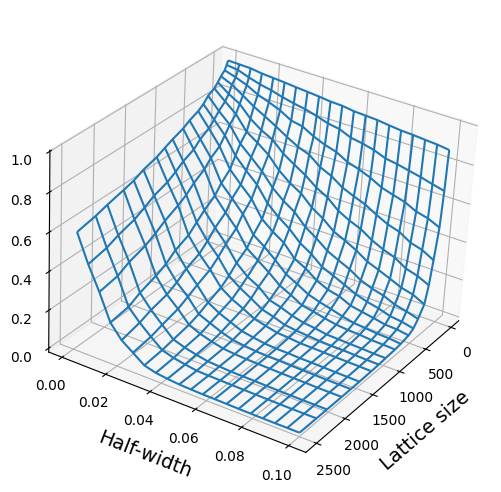

In [32]:
sizes_grid, widths_grid = np.meshgrid(linear_sizes, half_widths)

fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection='3d', elev=29., azim=31., roll=-3)
ax.plot_wireframe(sizes_grid ** 2, widths_grid, acceptance_grid)
ax.set_xlabel("Lattice size", fontsize=14, labelpad=7)
ax.set_ylabel("Half-width", fontsize=14, labelpad=7)
ax.set_zlabel("Mean acceptance", fontsize=14, labelpad=3)
plt.show()

In [ ]:
data_file = "data/metro_mean_acceptance_size.npy"
linear_sizes = np.array([5 + i for i in range(46)])
num_samples = 50_000
half_width = 0.05

if Path(data_file).exists():
    mean_acceptances = np.load(data_file)
else:
    mean_acceptances = []

    for linear_size in linear_sizes:
        print(f"Linear size: {linear_size}")
        rng = np.random.default_rng(seed=42)  # Reseed for every size, so that they can be reproduced in any order.
        lattice = Phi4Lattice(linear_sites=linear_size, mass2=-1.0, coupling_strength=8.0)
        initial_sample = rng.random(size=lattice.shape)
        _, acceptances = lattice.sample(initial_sample=initial_sample,
                                        num_samples=num_samples,
                                        method='uniform',
                                        rng=rng,
                                        half_width=half_width)
        mean_acceptances.append(np.mean(acceptances))

    mean_acceptances = np.array(mean_acceptances)
    np.save(data_file, mean_acceptances)

In [ ]:
x_values = linear_sizes ** 2

def exp_fit(x, A, k, p, x0):
    return A * np.exp(-k * np.power((x - x0), p))

params = curve_fit(exp_fit, x_values, mean_acceptances, p0=[0.93401502, 0.01804902, 0.70714088, 0.])[0]

fig, ax = plt.subplots()
ax.scatter(x_values, mean_acceptances, label="Data points", linewidths=0, s=42)
ax.plot(x_values, exp_fit(x_values, *params), color='red', label="Exponential fit")
ax.set_xlabel("Lattice sites", fontsize=14, labelpad=10)
ax.set_ylabel("Mean acceptance", fontsize=14, labelpad=10)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
plt.legend(fontsize=11)
plt.show()